In [12]:
import open3d as o3d
import time
import skvideo.io 
import skimage.io
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Make Scikit-Video happy
np.float = np.float64
np.int = np.int_

In [2]:
DATA_PATH = Path("data/6070fae025")

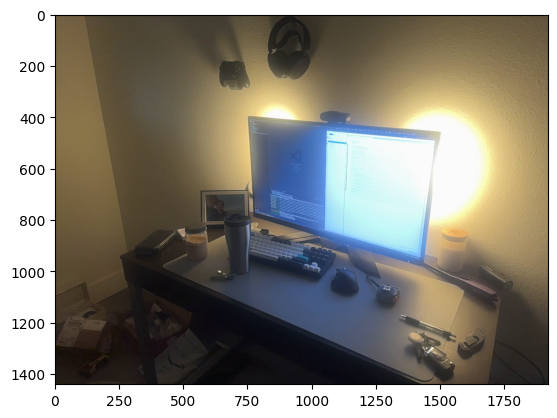

In [3]:
video_data = skvideo.io.vread(str(DATA_PATH.joinpath("rgb.mp4")))
rgb_image = video_data[0]

height = rgb_image.shape[0]
width = rgb_image.shape[1]

plt.imshow(rgb_image)

In [4]:
calibration_matrix = np.genfromtxt(DATA_PATH.joinpath("camera_matrix.csv"), delimiter=',')
calibration_matrix

array([[1.3398461e+03, 0.0000000e+00, 9.5837756e+02],
       [0.0000000e+00, 1.3398461e+03, 7.2530835e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

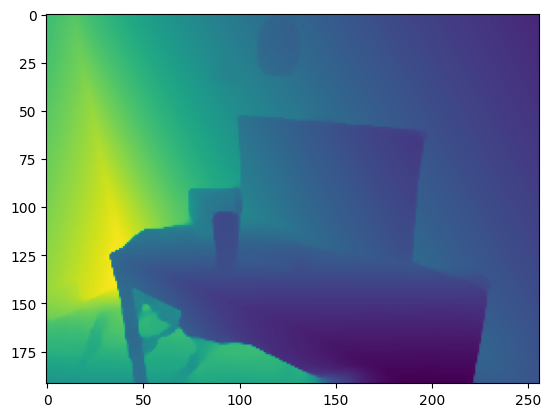

In [5]:
depth_image = skimage.io.imread(sorted(list(DATA_PATH.glob("depth/*.png")))[0])
plt.imshow(depth_image)

In [42]:
# Ray from Point in Image:
# Ideas from https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
# And https://stackoverflow.com/questions/68249598/how-to-calculate-the-ray-of-a-camera-with-the-help-of-the-camera-matrix

# inv_camera_matrix = np.linalg.inv(camera_matrix)
world_to_camera_matrix = np.eye(3, 4) # We assume world + Camera share coordinate system

camera_matrix = np.matmul(calibration_matrix, world_to_camera_matrix)

# Calculate the Moore-Penrose pseudoinverse (since we can't solve directly for 3d points from 2d, only 
# direction, we need this to get a direction, but not depth info)
camera_matrix_inv = np.linalg.pinv(camera_matrix)


xv, yv = np.meshgrid(np.arange(width), np.arange(height))
all_pixels = np.stack([xv.ravel(), yv.ravel(), np.ones_like(xv).ravel()], axis=1)

# Upscale depth to the same as our RGB image
upscaled_depth_image = skimage.transform.resize(depth_image, rgb_image.shape[0:2])

direction = np.matmul(camera_matrix_inv, all_pixels.T).T
direction = direction / np.linalg.norm(direction)
direction = direction * upscaled_depth_image.reshape(-1, 1) # Add Depth info!

In [47]:

# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=480, width=640)

pcd = o3d.geometry.PointCloud()

points = direction[:, 0:3]
pcd.points = o3d.utility.Vector3dVector(points)

colors = (rgb_image.reshape(-1,3).astype('float32') / 255.0)
pcd.colors = o3d.utility.Vector3dVector(colors)

vis.add_geometry(pcd)

# run non-blocking visualization. 
# To exit, press 'q' or click the 'x' of the window.
keep_running = True
while keep_running:
    keep_running = vis.poll_events()
    vis.update_renderer()

vis.destroy_window()